In [1]:
import re #importing regex
import csv #csv reader
import numpy as np
#from sklearn.svm import LinearSVC #assumes data is linearly separable, and faster for high-dimensional sparse text features
!pip install xgboost #download xgboost package first
import xgboost as xgb
from xgboost import XGBClassifier
from nltk.classify import SklearnClassifier
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import WordNetLemmatizer #importing WordNetLemmatizer to lemmatize words into lemmas
from nltk.corpus import stopwords #importing all common stop words
from scipy import sparse   # used to convert dense numeric features into sparse matrices for stacking
from sklearn.model_selection import StratifiedKFold, GridSearchCV  # used in cross validation / grid search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.2 MB/s eta 0:00:00


In [2]:
nltk.download('wordnet') #run only once
nltk.download('stopwords') #run only once

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [4]:
import requests

class LexiconFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Custom transformer to add features from external opinion lexicons (Bing Liu). It adds [Positive_Count, Negative_Count, Polarity_Score, Intense_Punctuation_Count].
    """
    def __init__(self, pos_file=None, neg_file=None, try_download=True):
        self.pos_words = set()
        self.neg_words = set()
        self._tried_to_download = False

        # 1) Try reading local files if provided
        if pos_file:
            try:
                with open(pos_file, 'r', encoding='utf-8', errors='ignore') as pf:
                    self.pos_words = set(word.strip().lower() for word in pf if word.strip() and not word.strip().startswith(';'))
            except FileNotFoundError:
                pass
        if neg_file:
            try:
                with open(neg_file, 'r', encoding='utf-8', errors='ignore') as nf:
                    self.neg_words = set(word.strip().lower() for word in nf if word.strip() and not word.strip().startswith(';'))
            except FileNotFoundError:
                pass

        # 2) If either lexicon is missing and try_download is True, attempt to fetch from a public raw mirror
        if try_download and (not self.pos_words or not self.neg_words):
            self._tried_to_download = True
            try:
                pos_url = "https://gist.githubusercontent.com/mkulakowski2/4289437/raw/positive-words.txt"
                neg_url = "https://gist.githubusercontent.com/mkulakowski2/4289441/raw/negative-words.txt"

                if not self.pos_words:
                    rpos = requests.get(pos_url, timeout=10)
                    if rpos.status_code == 200:
                        lines = rpos.text.splitlines()
                        self.pos_words = set(w.strip().lower() for w in lines if w.strip() and not w.strip().startswith(';'))

                if not self.neg_words:
                    rneg = requests.get(neg_url, timeout=10)
                    if rneg.status_code == 200:
                        lines = rneg.text.splitlines()
                        self.neg_words = set(w.strip().lower() for w in lines if w.strip() and not w.strip().startswith(';'))
            except Exception:
                # network error or requests not installed: fall through to fallback
                pass

        if (not self.pos_words) or (not self.neg_words):
            if self._tried_to_download:
                print("Could not download the positive/negative lexicon files.")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_texts = len(X)
        num_features = 4
        features = np.zeros([num_texts, num_features])  # pos_count, neg_count, polarity_score, intense_punct_count

        for i, text in enumerate(X):
            words = re.findall(r'\b\w+\b', text.lower())  # simple word tokenization
            intense_punct_count = len(re.findall(r'(\!{2,}|\?{2,})', text))  # count repeated ! or ?

            pos_count = sum(1 for word in words if word in self.pos_words)
            neg_count = sum(1 for word in words if word in self.neg_words)
            polarity_score = pos_count - neg_count

            features[i] = [pos_count, neg_count, polarity_score, intense_punct_count]

        # convert to sparse CSR so FeatureUnion can hstack with TF-IDF sparse matrices efficiently
        return sparse.csr_matrix(features)

In [5]:
def to_feature_vector(data, preprocessor_func, train=False):
    """
    Updated feature extraction function using FeatureUnion and TF-IDF/N-grams.
    If 'train' is True, it returns the fitted FeatureUnion object for use in 'train_classifier'.
    If 'train' is False, it returns the feature matrix (X) transformed by the fitted union.
    """
    # Word-level TF-IDF (uses your pre_process tokenizer)
    '''ngram_vectorizer = TfidfVectorizer( #TF-IDF features as n-grams
        tokenizer=lambda x: pre_process(x, lemmatizer, stop_words), # tokenizing each sentence using the tools passed
        ngram_range=(1, 2), #unigrams and bigrams (kept small to be robust)
        sublinear_tf=True,
        max_df=0.85,
        min_df=3,
        max_features=10000 #vocabulary size limited to 10000 features
    )

    # Character-level TF-IDF: helps with misspellings, elongations (soooo), emotive punctuation patterns
    char_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3,5),
        sublinear_tf=True,
        max_df=0.85,
        min_df=3,
        max_features=5000
    )'''
    ngram_vectorizer = TfidfVectorizer( #TF-IDF features as n-grams
        tokenizer=lambda x: pre_process(x, lemmatizer, stop_words), # tokenizing each sentence using the tools passed
        ngram_range=(1, 3), #include trigrams (unigrams, bigrams, trigrams)
        sublinear_tf=True,
        max_df=0.8,   #slightly stricter to remove very common tokens
        min_df=2,     #lower min_df to include rarer but informative tokens
        max_features=15000 # slightly larger vocab to accommodate trigrams
    )

    char_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3, 5),
        sublinear_tf=True,
        max_df=0.85,
        min_df=2,
        max_features=8000
    )


    # Lexicon features (the class returns a sparse matrix now), NOTE: used lexicons from https://gist.githubusercontent.com/mkulakowski2/4289437/raw/
    lexicon_extractor = LexiconFeatureExtractor( #Lexicon features
        pos_file='positive-words.txt',
        neg_file='negative-words.txt'
    ) #The files are available on the following webpage, under the section "Opinion Lexicon": https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

    # Small stylistic numeric features (length, ! count, ? count, uppercase ratio, url, mention)
    class StyleFeatureExtractor(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            out = []
            for text in X:
                length = len(text)
                exclamation_marks = text.count('!')
                question_marks = text.count('?')
                upper_ratio = sum(1 for char in text if char.isupper()) / (length + 1)
                has_url = 1 if ('http' in text or 'www.' in text) else 0
                has_mention = 1 if '@' in text else 0
                out.append([length, exclamation_marks, question_marks, upper_ratio, has_url, has_mention])
                sparse_matrix = sparse.csr_matrix(np.array(out))
            return sparse_matrix #convert to sparse to stack with TF-IDF and retuen sparse matrix

    style_extractor = StyleFeatureExtractor()

    feature_union = FeatureUnion([ #combining features using FeatureUnion
        ('ngram_features', ngram_vectorizer),
        ('char_features', char_vectorizer),
        ('lexicon_features', lexicon_extractor),
        ('style_features', style_extractor)
    ], n_jobs = -1)

    if train:
        feature_union.fit(data) #for training, fit the union to the data and return it
        return feature_union
    else:
        return feature_union.transform(data) #assumes 'feature_union' is a global or passed variable that was previously fitted in 'train_classifier'


In [6]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((text, label)) # Append raw text and label
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((text, label)) # Append raw text and label

def parse_data_line(data_line):
    """Return a tuple of the label as just FAKE or REAL and the statement"""
    return (data_line[1], data_line[2])

def pre_process(text, lemmatizer, stop_words):
    preprocessed_tokens = []
    negation_tokens = ['not', 'no', 'never', "n't"]  # common negation words

    # Normalizing and removing noisy tokens from texts
    text = re.sub(r'\bRT\b', '', text) #remove RT tokens
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text) #replace urls with placeholder
    text = re.sub(r'@\w+', ' MENTION ', text) #replace mentions with placeholder
    text = re.sub(r'(.)\1{2,}', r'\1\1', text) #collapse repeated characters (like "soooo" to "soo")
    text = text.lower()     #lowercasing after placeholders and elongation normalization
    # tidy up whitespace produced by replacements
    text = re.sub(r'\s+', ' ', text).strip()
    # 2) Tokenization: include punctuation tokens so we can use them to delimit negation scope
    tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)

    i = 0
    while i < len(tokens):
        token = tokens[i]

        #Negation handling
        if token in negation_tokens:
            preprocessed_tokens.append(lemmatizer.lemmatize(token)) # keeping the negation token as it is
            j = i + 1
            steps = 0
            while j < len(tokens) and steps < 3: #prefix following up to 3 tokens or until punctuation
                next_token = tokens[j]
                if re.match(r'[.!?,;:]', next_token): #stop negation handling scope when punctuation is reached
                    break
                # only add real word tokens (skip placeholders already added as MENTION/URL)
                if next_token not in stop_words and re.match(r'\w+', next_token):
                    lemmatized_next = lemmatizer.lemmatize(next_token)
                    preprocessed_tokens.append(f'NOT_{lemmatized_next}')
                    steps += 1
                j += 1
            i = j  #continue after negation hangling scope
            continue

        #dropping stopwords and lemmatizing
        if token not in stop_words and re.match(r'\w+', token):
            preprocessed_tokens.append(lemmatizer.lemmatize(token))
        i += 1

    return preprocessed_tokens #return list of tokens for TfidfVectorizer's tokenizer

In [7]:
# test
text = "RT @colonelkickhead: Another bloody instant restaurant week?!?! Seriously! They just jumped the shark riding two other sharks powered by sh…"
pre_process(text, lemmatizer, stop_words)

['mention',
 'another',
 'bloody',
 'instant',
 'restaurant',
 'week',
 'seriously',
 'jumped',
 'shark',
 'riding',
 'two',
 'shark',
 'powered',
 'sh']

In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
# Assuming 'to_feature_vector' is defined elsewhere and returns the FeatureUnion

def train_classifier(train_data):
    train_texts = [row[0] for row in train_data]
    train_labels = [row[1] for row in train_data]

    le = LabelEncoder()
    # Transform string labels ('negative', 'positive') to integers (e.g., 0, 1)
    train_labels_encoded = le.fit_transform(train_labels)

    # Calculate and sample weights for class imbalance
    #calculate the weight for each class label
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=le.classes_,
        y=train_labels # Use the original string labels here
    )
    #mapping the calculated weights to the encoded labels (0 and 1)
    weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    #create an array of sample weights, matching the length of the training data
    sample_weights = np.array([weight_dict[label] for label in train_labels_encoded])

    # Build the FeatureUnion fitted on training texts
    # IMPORTANT: Ensure to_feature_vector can handle passing features to a tree-based model
    # (i.e., the output from FeatureUnion must be compatible, which it should be since it's sparse/dense)
    feature_union = to_feature_vector(train_texts, pre_process, train=True) # returns the fitted FeatureUnion object

    # --- CLASSIFIER: XGBOOST ---
    # XGBoost is excellent for leveraging your mix of sparse (TF-IDF) and dense (Lexicon/Style) features.
    xgb_classifier = XGBClassifier(
        objective='multi:softmax', #standard for multi-class classification
        num_class=2,
        eval_metric='merror', #metric to monitor: multi-class error rate
        n_estimators=200, #number of boosting rounds (trees) - start here
        learning_rate=0.1, #controls step size - tune this aggressively
        max_depth=5, #tree depth - tune between 3 and 7
        random_state=42,
        #use_label_encoder=False, #suppress warning
        # Calculate 'scale_pos_weight' based on the ratio of the majority class to the minority class
        # (e.g., if negative samples are 2x positive samples, use 2.0).
        # You will need to calculate this from your data. Using 1.0 here as a neutral placeholder.
        # This is CRITICAL for balancing the F1 score.
        #scale_pos_weight=1.0
    )

    pipeline = Pipeline([
        ('features', feature_union),
        ('classifier', xgb_classifier)
    ])

    #pipeline.fit(train_texts, train_labels) # training the pipeline
    pipeline.fit(train_texts, train_labels_encoded, classifier__sample_weight=sample_weights) ## Use the step name 'classifier' followed by '__' and the parameter name 'sample_weight'

    return pipeline, le


In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()


In [10]:
from sklearn.metrics import classification_report, accuracy_score


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        train_set = dataset[ : i] + dataset[i+fold_size : ] # the train set contains the remaining rows apart from the fold
        test_set = dataset[i : i+fold_size] # the test set contains the rows within the fold

        classifier, le = train_classifier(train_set)

        test_data = [row[0] for row in test_set] #list comprehension to get all the text data in the test set
        y_true = [row[1] for row in test_set] #list comprehension to get all the corresponding text labels in the test set

        #checking to see if the dataset is imbalanced (It is imbalanced by observation)
        #pos_counts = np.sum([1 for label in y_true if label == "positive"])
        #neg_counts = np.sum([1 for label in y_true if label == "negative"])
        #print(f"No.of texts with positive sentiment: {pos_counts}")
        #print(f"No.of texts with negative sentiment: {neg_counts}")

        #predictions are numeric (0 or 1)from XGBoost
        y_pred_encoded = predict_labels(test_data, classifier)

        #decode predictions back to strings for eval
        y_pred = le.inverse_transform(y_pred_encoded)

        #y_pred = predict_labels(test_data, classifier)

        accuracy = accuracy_score(y_true, y_pred)

        #using weighted average to compute the metrics since dataset is imbalanced
        precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

        results.append({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score})
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

        '''Performing error analysis (as stated in Question #3) on the first fold'''
        if i == 0:
            print("---------------------------------------Error Analysis on the first fold (as per Question #3)-----------------------------------------------")
            labels = ["positive", "negative"]
            confusion_matrix_heatmap(y_true, y_pred, labels)

            #using list comprehension to identify the true positives and true negatives for the positive class in the first fold
            true_positives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "positive" and y_true[j] == "positive"]
            true_negatives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "negative" and y_true[j] == "negative"]

            #using list comprehension to identify the false positives and false negatives for the positive class in the first fold
            false_positives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "positive" and y_true[j] == "negative"]
            false_negatives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "negative" and y_true[j] == "positive"]

            print("Number of false positives: ",len(false_positives))
            print("Number of false negatives: ", len(false_negatives))

            batch_of_true_positives = true_positives[:5] #5 examples to just show
            batch_of_true_negatives = true_negatives[:5] #5 examples to just show
            batch_of_false_positives = false_positives[:5] #5 examples to just show
            batch_of_false_negatives = false_negatives[:5] #5 examples to just show

            print("\n")
            print("First 5 examples of False Positives:")
            for false_pos in false_positives[:5]:
                print(false_pos)

            print("\n")
            print("First 5 examples of False Negatives:")
            for false_neg in false_negatives[:5]:
                print(false_neg)

            print("\n")
            print("First 5 examples of True Positives:")
            for false_pos in true_positives[:5]:
                print(false_pos)

            print("\n")
            print("First 5 examples of True Negatives:")
            for false_neg in true_negatives[:5]:
                print(false_neg)
            print("--------------------------------------------------------------------------------------------------------------------------------------------")

    accuracies = [result["accuracy"] for result in results]
    precisions = [result["precision"] for result in results]
    recalls = [result["recall"] for result in results]
    f1_scores = [result["f1_score"] for result in results]

    cv_results = {"accuracy" : float(np.mean(accuracies)), "precision" : float(np.mean(precisions)),
                  "recall" : float(np.mean(recalls)), "f1_score" : float(np.mean(f1_scores))}

    return cv_results

In [11]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    # Since the classifier is an sklearn Pipeline, use its predict method.
    return classifier.predict(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    # Use pipeline.predict on a single raw sample after it is wrapped in a list
    return classifier.predict([sample])[0]

In [12]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
#print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
#      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...


Fold start on items 0 - 2684
Accuracy: 0.8543219076005961, Precision: 0.8585332978024204, Recall: 0.8543219076005961, F1 Score: 0.8558559926201523
---------------------------------------Error Analysis on the first fold (as per Question #3)-----------------------------------------------


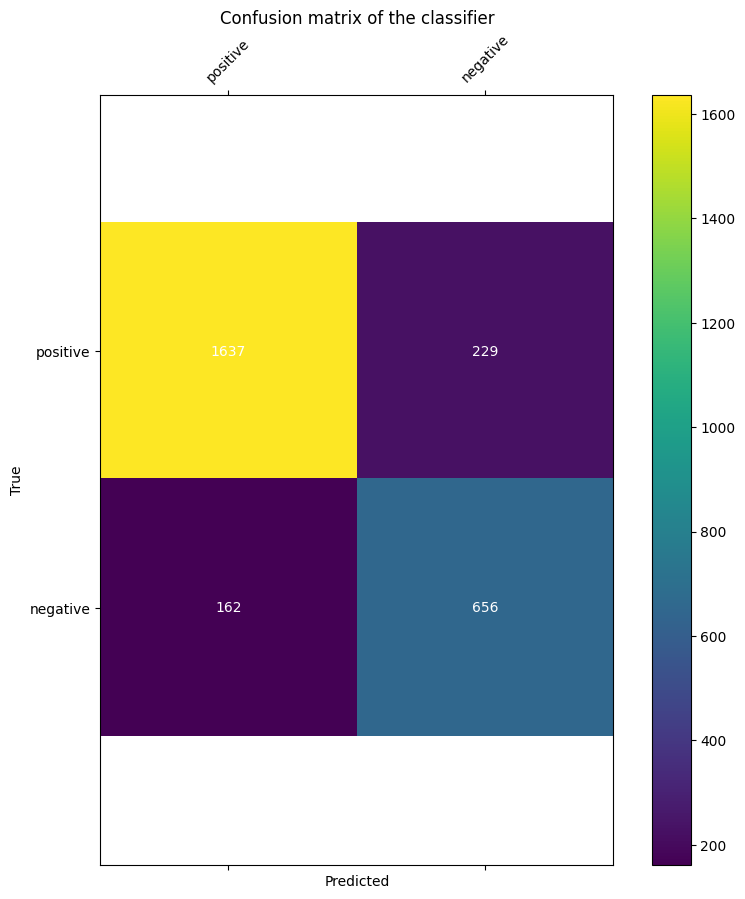

Number of false positives:  162
Number of false negatives:  229


First 5 examples of False Positives:
@AngryRaiderFan I know. This, TPP, expanded wars and drone strikes, mass surveillance, on and on...
Nicki's pastor is mad af right now. And it's Sunday smh
@nytimes And in good news tonight, Fidel Castro assumed room temperature. Now we just need his brother and Maduro to follow. Quickly.
Italian police stopped California rapper Snoop Dogg on Friday as he prepared to board a private plane bound for... http://t.co/DH38uKpUZI
Buhari has shifted his campaign promise on Boko Haram. Now claims he will end BH by December instead of 2months. Nigerians have been scammed


First 5 examples of False Negatives:
@Jacknonce Sorry, the blacks I know are actually great, successful people.They aren't taken in by Dems BS. They are very smart, educated!
I have heard it said that the 2nd G in Snoop Dogg represents extra gangsterishness, for how else do you explain this particular redundancy?
Let me be t

In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

("Tomorrow we'll release our 58th episode of #HSonAir profiling our very own @AlissaDosSantos ! We'll talk about storytelling and Beyonce!", 'positive')
